# Additional dataset: Anemia Types Classification

##  Preparing the datasets


### Load the Data

In [1]:
import pandas as pd

data = pd.read_csv("data/diagnosed_cbc_data_v4.csv")

print("\nMissing Values in Each Column:")
print(data.isnull().sum())

# Check the distribution of the target variable
print("\nDiagnosis Distribution:")
print(data['Diagnosis'].value_counts())



Missing Values in Each Column:
WBC          0
LYMp         0
NEUTp        0
LYMn         0
NEUTn        0
RBC          0
HGB          0
HCT          0
MCV          0
MCH          0
MCHC         0
PLT          0
PDW          0
PCT          0
Diagnosis    0
dtype: int64

Diagnosis Distribution:
Diagnosis
Healthy                           336
Normocytic hypochromic anemia     279
Normocytic normochromic anemia    269
Iron deficiency anemia            189
Thrombocytopenia                   73
Other microcytic anemia            59
Leukemia                           47
Macrocytic anemia                  18
Leukemia with thrombocytopenia     11
Name: count, dtype: int64


### Preprocess the Data
Diagnosis Encoding:
- Normal (Healthy) → 0
- Iron-Related Anemia → 1
- Non-Iron-Related Anemia → 2
- Blood Disorders → 3

Seperate features and Labels

In [2]:
# No missing data

# Group and encode the 'Diagnosis' column
def group_diagnosis(diagnosis):
    if diagnosis == "Healthy":
        return 0  # Normal
    elif diagnosis in ["Iron deficiency anemia", "Normocytic hypochromic anemia", "Other microcytic anemia"]:
        return 1  # Iron-Related Anemia
    elif diagnosis in ["Normocytic normochromic anemia", "Macrocytic anemia"]:
        return 2  # Non-Iron-Related Anemia
    else:
        return 3  # Blood Disorders

data['Diagnosis'] = data['Diagnosis'].apply(group_diagnosis)

# Remove unnecessary columns
# No ID column mentioned in the anemia dataset, so skipping this step

# Separate features and labels
features = data.drop(columns=["Diagnosis"]).values  # CBC parameters
labels = data["Diagnosis"].values  # Encoded Diagnosis labels



In [3]:
print("\nDiagnosis Distribution:")
print(data['Diagnosis'].value_counts())


Diagnosis Distribution:
Diagnosis
1    527
0    336
2    287
3    131
Name: count, dtype: int64


### Shuffle and Split the Dataset

In [4]:
from sklearn.model_selection import train_test_split

# Splits and stratification
proportions = [40, 60, 80, 90]
splits = {}
for prop in proportions:
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, train_size=prop/100, stratify=labels, random_state=42
    )
    splits[f"{int(prop)}_{int(100-prop)}"] = (X_train, X_test, y_train, y_test)


### Visualize Class Distributions

Shortened Class Names:
- "Normal" remains the same.
- "Iron-Ana" for "Iron-Related Anemia".
- "Non-Iron" for "Non-Iron-Related Anemia".
- "Bld-Dis" for "Blood Disorders".

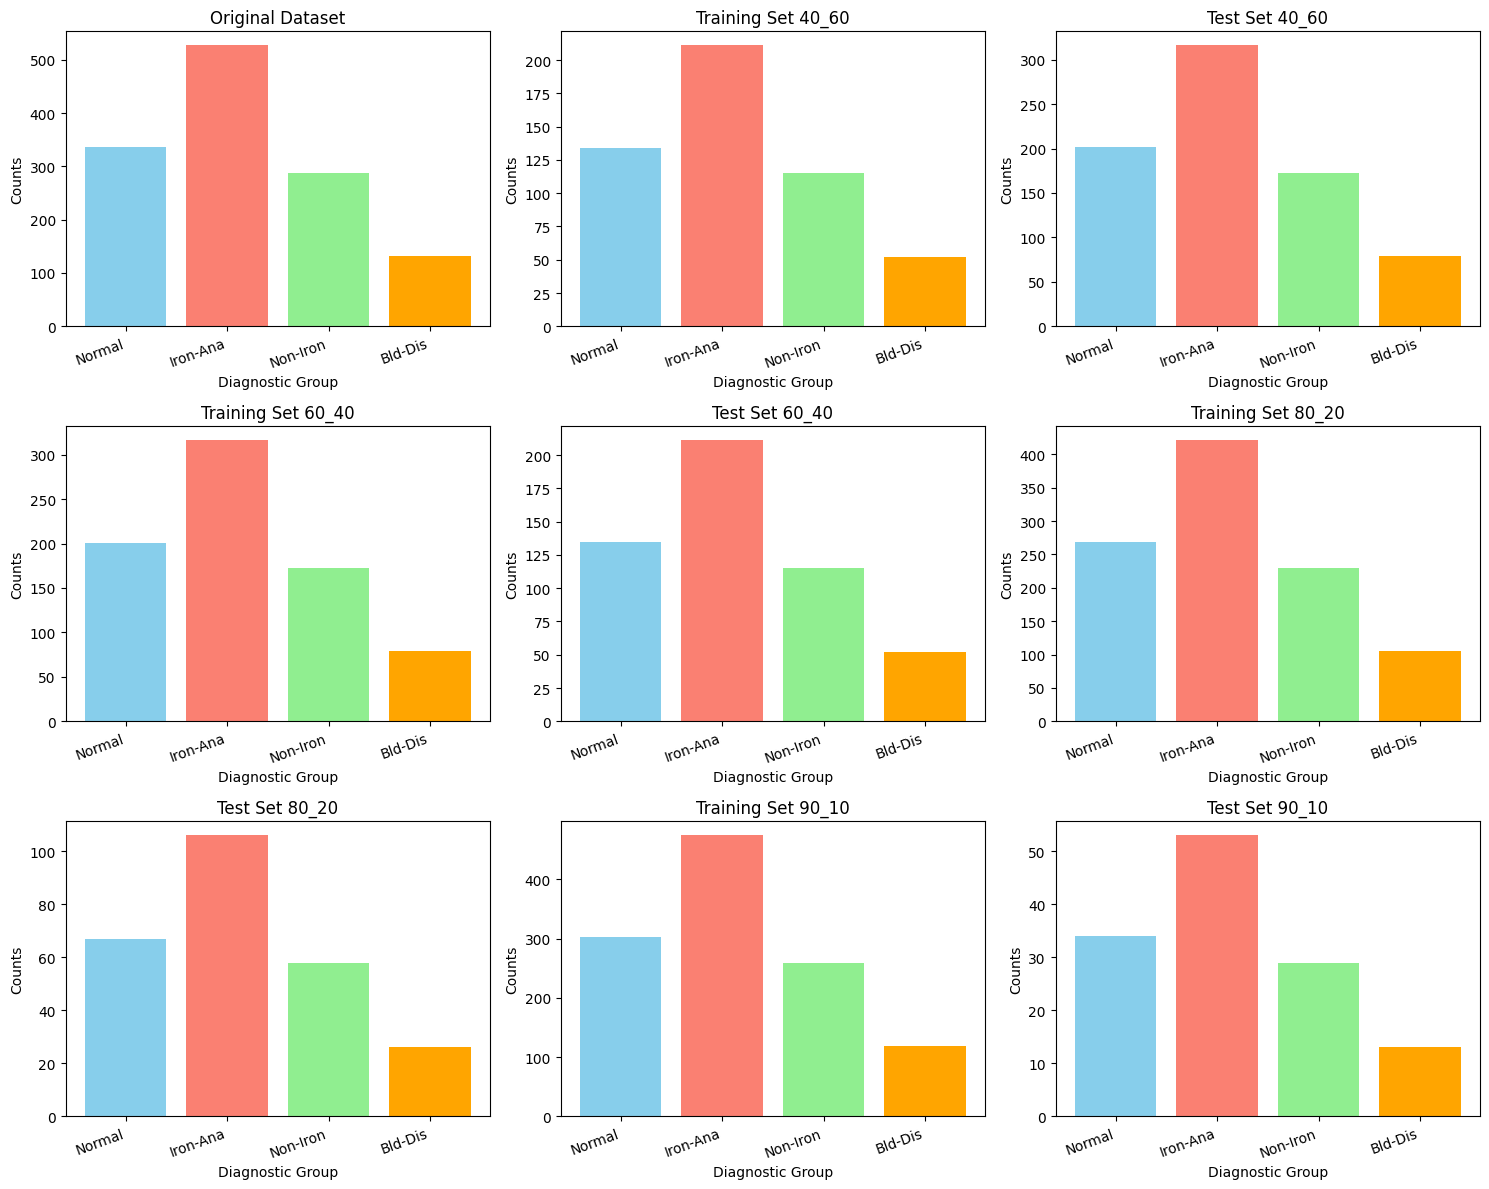

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_distribution(ax, title, data_labels):
    unique, counts = np.unique(data_labels, return_counts=True)
    class_names = ["Normal", "Iron-Ana", "Non-Iron", "Bld-Dis"] 
    ax.bar(class_names, counts, color=["skyblue", "salmon", "lightgreen", "orange"])
    ax.set_title(title)
    ax.set_xlabel("Diagnostic Group")
    ax.set_ylabel("Counts")
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=20, ha="right")  

# Number of splits
num_splits = len(splits)
total_plots = 1 + num_splits * 2  # Original + training + test sets
rows = (total_plots + 2) // 3  
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.flatten()

# original dataset
plot_distribution(axes[0], "Original Dataset", labels)

# each split
plot_idx = 1
for key, (X_train, X_test, y_train, y_test) in splits.items():
    plot_distribution(axes[plot_idx], f"Training Set {key}", y_train)
    plot_idx += 1
    plot_distribution(axes[plot_idx], f"Test Set {key}", y_test)
    plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()


## Building the decision tree classifiers

Decision Tree Graph for Split 40_60:


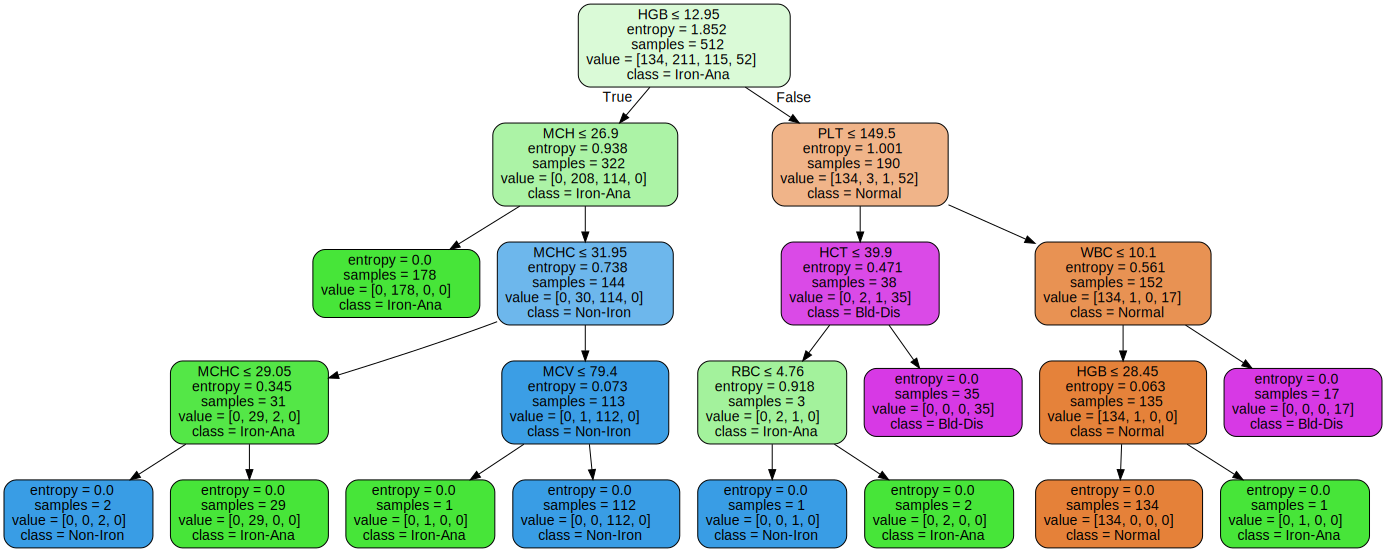

Classification Report for Split 40_60:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       202
    Iron-Ana       0.98      0.99      0.99       316
    Non-Iron       0.99      0.97      0.98       172
     Bld-Dis       1.00      1.00      1.00        79

    accuracy                           0.99       769
   macro avg       0.99      0.99      0.99       769
weighted avg       0.99      0.99      0.99       769



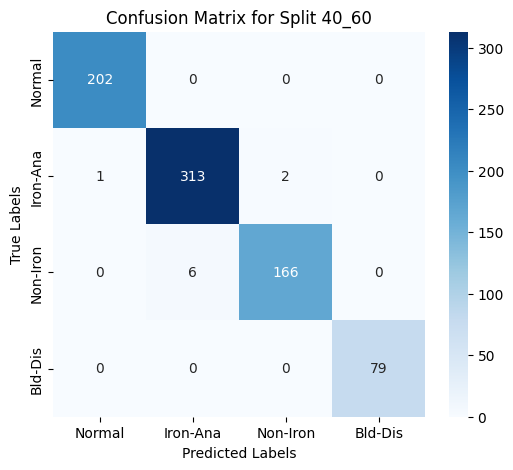

Decision Tree Graph for Split 60_40:


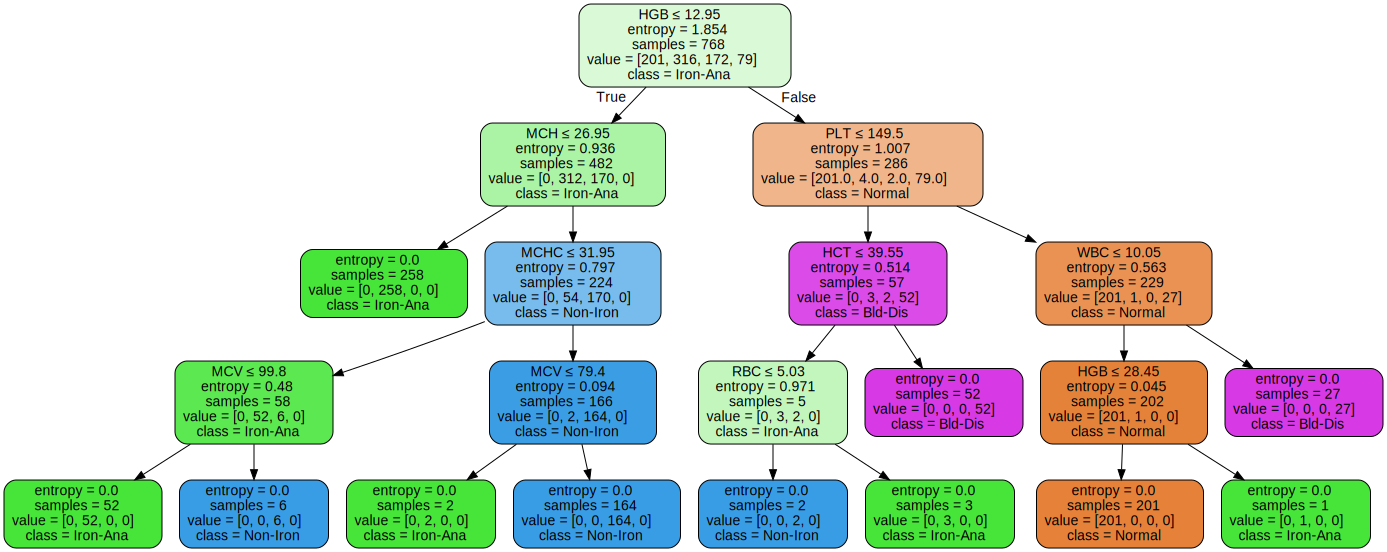

Classification Report for Split 60_40:
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       135
    Iron-Ana       1.00      0.99      1.00       211
    Non-Iron       0.99      1.00      1.00       115
     Bld-Dis       1.00      1.00      1.00        52

    accuracy                           1.00       513
   macro avg       1.00      1.00      1.00       513
weighted avg       1.00      1.00      1.00       513



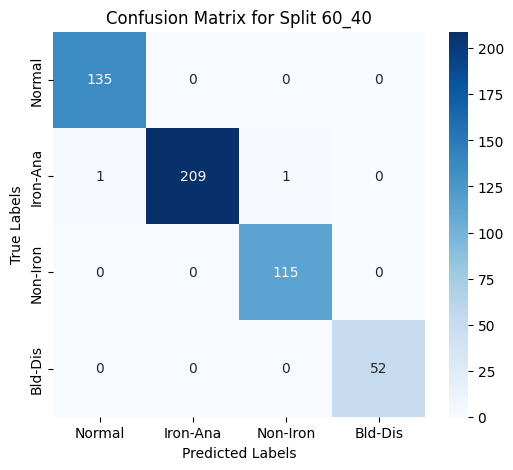

Decision Tree Graph for Split 80_20:


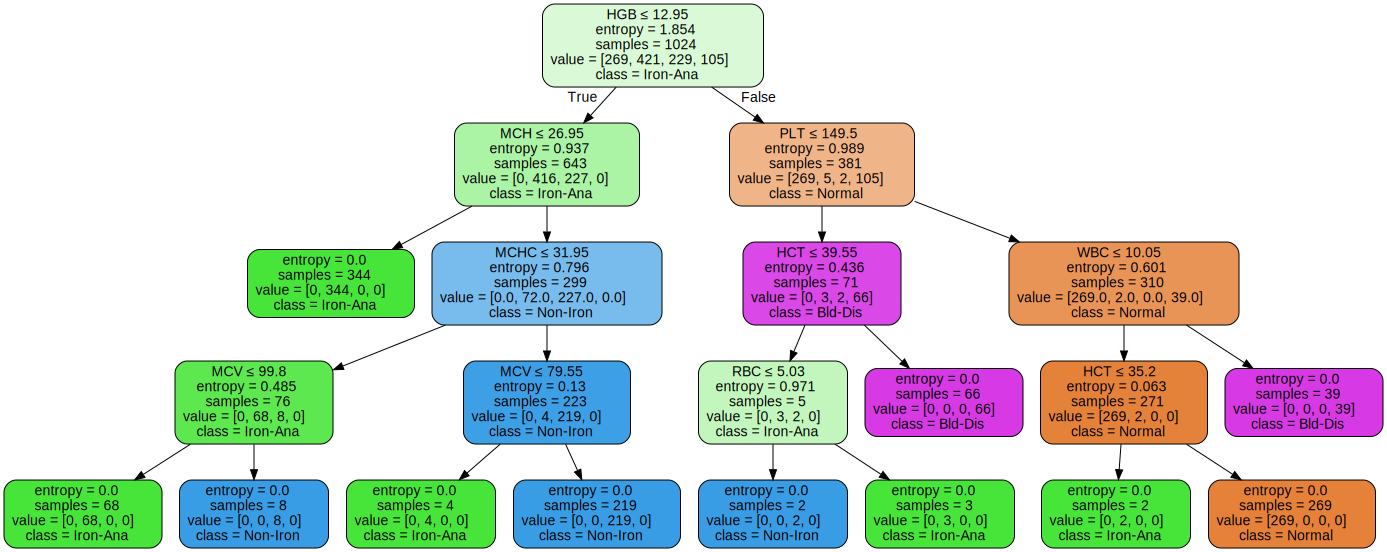

Classification Report for Split 80_20:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        67
    Iron-Ana       1.00      0.99      1.00       106
    Non-Iron       0.98      1.00      0.99        58
     Bld-Dis       1.00      1.00      1.00        26

    accuracy                           1.00       257
   macro avg       1.00      1.00      1.00       257
weighted avg       1.00      1.00      1.00       257



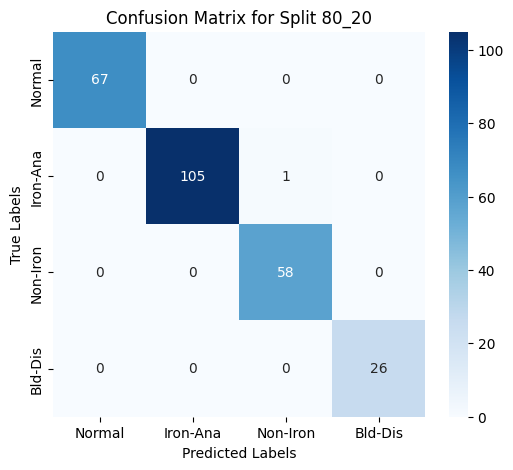

Decision Tree Graph for Split 90_10:


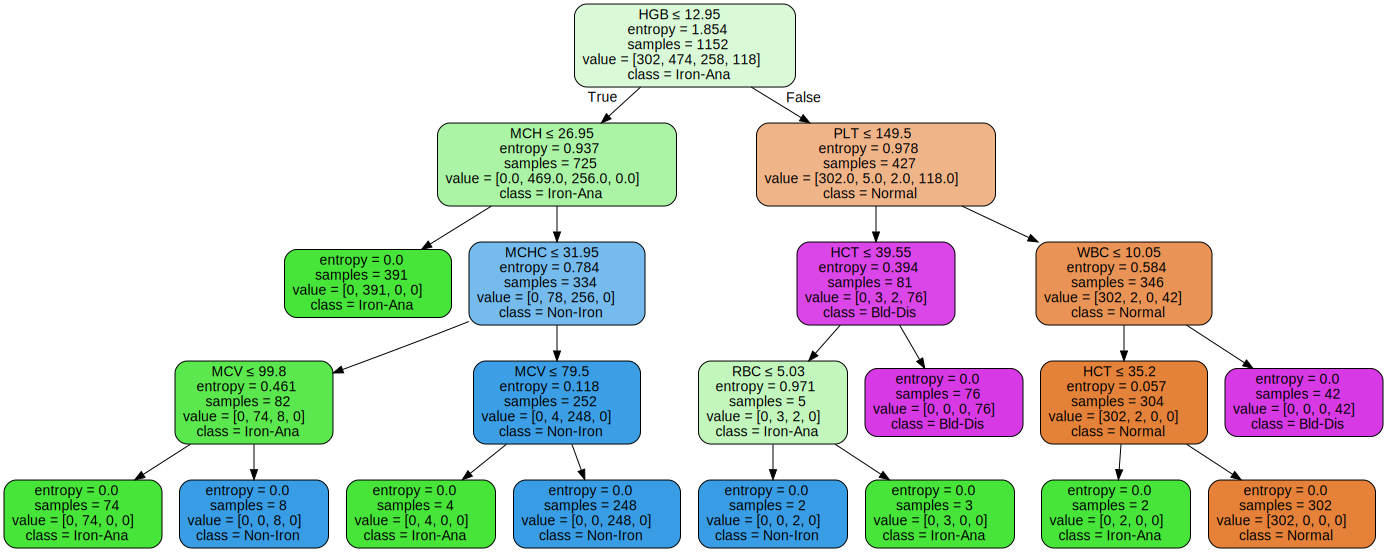

Classification Report for Split 90_10:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        34
    Iron-Ana       1.00      0.98      0.99        53
    Non-Iron       0.97      1.00      0.98        29
     Bld-Dis       1.00      1.00      1.00        13

    accuracy                           0.99       129
   macro avg       0.99      1.00      0.99       129
weighted avg       0.99      0.99      0.99       129



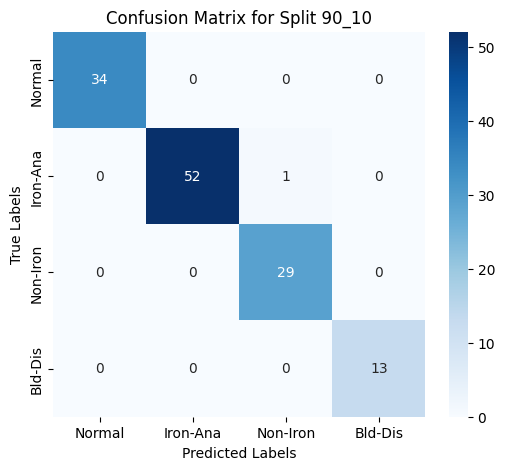

In [6]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for key, (X_train, X_test, y_train, y_test) in splits.items():
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(X_train, y_train)
    
    # export
    dot_data = export_graphviz(
        clf, 
        out_file=None,  
        feature_names=data.drop(columns=["Diagnosis"]).columns, 
        class_names=["Normal", "Iron-Ana", "Non-Iron", "Bld-Dis"],  
        filled=True,  
        rounded=True,  
        special_characters=True
    )
    

    graph = graphviz.Source(dot_data)
    graph.render(f"plots/dataset3/decision_tree_{key}", format="png") 
    #view graph
    print(f"Decision Tree Graph for Split {key}:")
    display(graph)

    # classification report
    y_pred = clf.predict(X_test)
    print(f"Classification Report for Split {key}:")
    print(classification_report(y_test, y_pred, target_names=["Normal", "Iron-Ana", "Non-Iron", "Bld-Dis"]))
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Iron-Ana", "Non-Iron", "Bld-Dis"], yticklabels=["Normal", "Iron-Ana", "Non-Iron", "Bld-Dis"])
    plt.title(f"Confusion Matrix for Split {key}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()



In [7]:
%%script echo skipping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a figure for the confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust grid size as needed
fig.suptitle("Confusion Matrices for All Splits", fontsize=16)

# Train and evaluate decision trees for all splits
for i, (key, (X_train, X_test, y_train, y_test)) in enumerate(splits.items()):
    # Train the decision tree classifier using information gain (entropy)
    clf = DecisionTreeClassifier(criterion="entropy", random_state=42)
    clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    
    # Generate and print classification report
    print(f"Classification Report for Split {key}:")
    print(classification_report(y_test, y_pred, target_names=["Normal", "Iron-Ana", "Non-Iron", "Bld-Dis"]))
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix in a subplot
    ax = axes[i // 2, i % 2]  # Determine subplot position
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=["Normal", "Iron-Ana", "Non-Iron", "Bld-Dis"], yticklabels=["Normal", "Iron-Ana", "Non-Iron", "Bld-Dis"],
        ax=ax
    )
    ax.set_title(f"Split {key}")
    ax.set_xlabel("Predicted Labels")
    ax.set_ylabel("True Labels")

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Reserve space for the main title
plt.show()


skipping


## The depth and accuracy of a decision tree

Decision Tree Graph for Max Depth None:


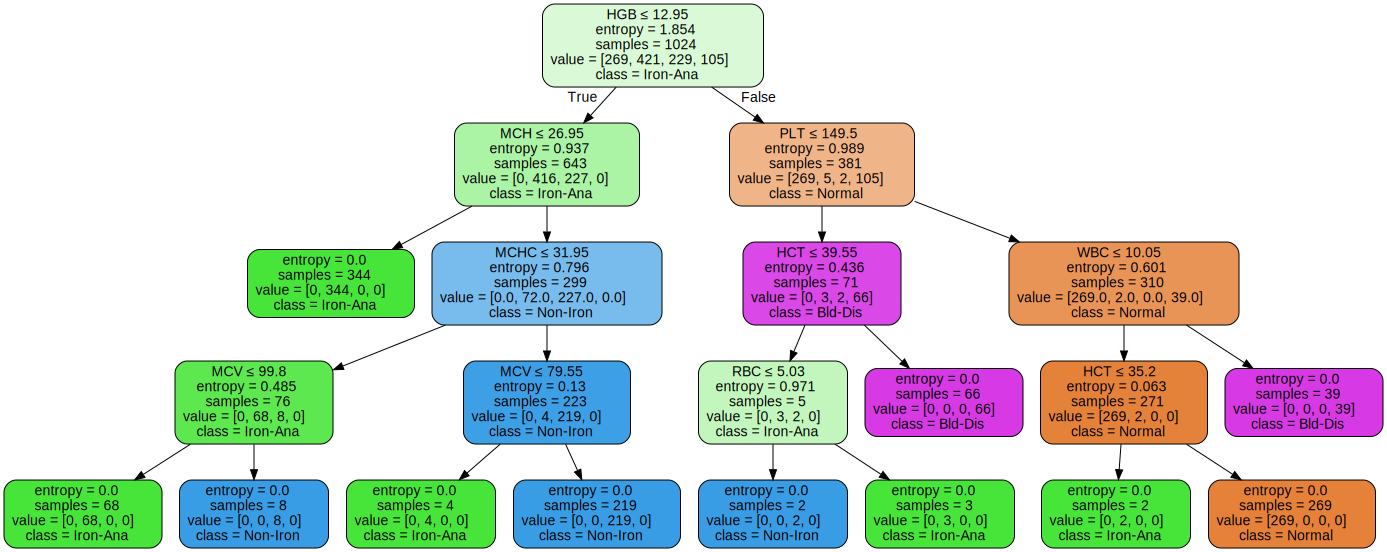

Decision Tree Graph for Max Depth 2:


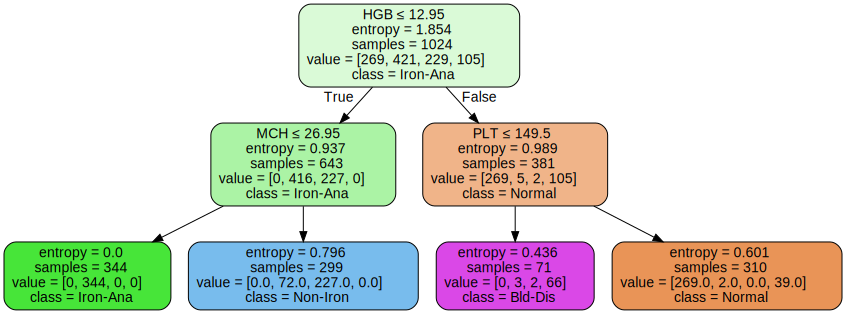

Decision Tree Graph for Max Depth 3:


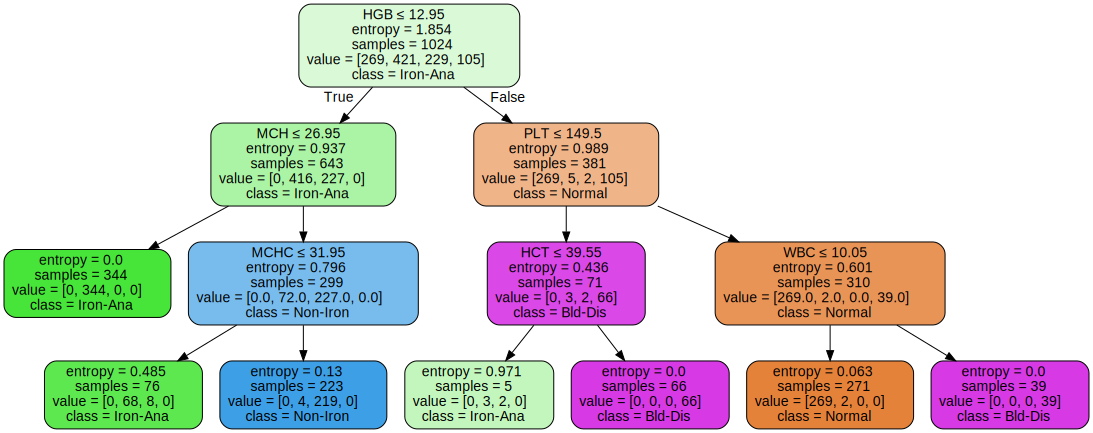

Decision Tree Graph for Max Depth 4:


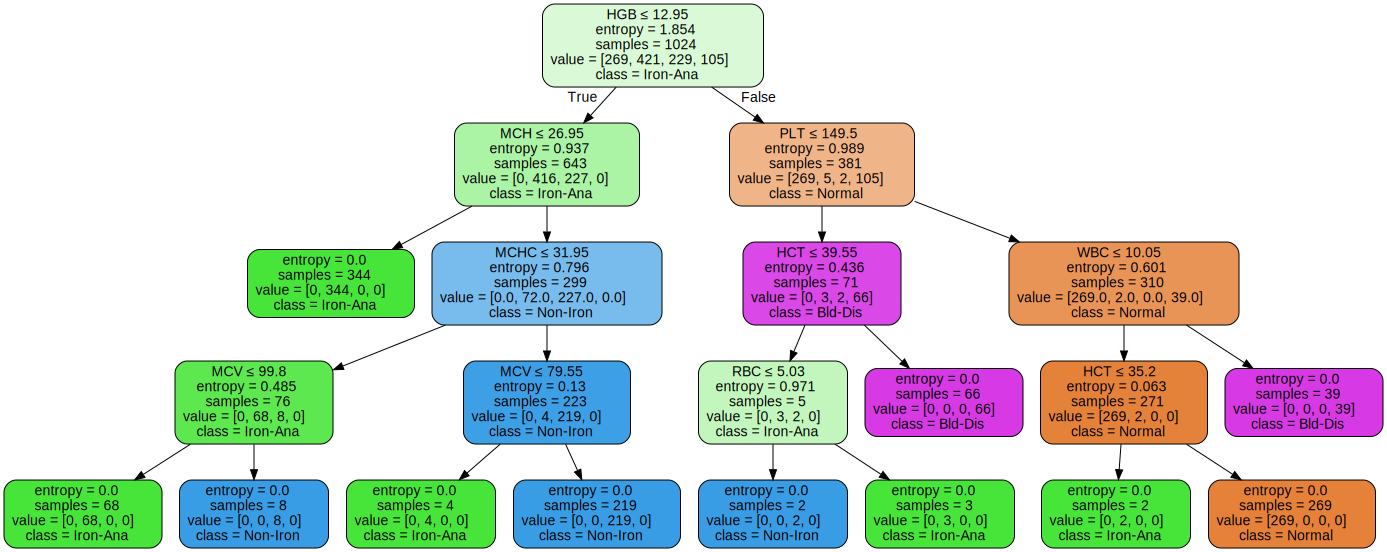

Decision Tree Graph for Max Depth 5:


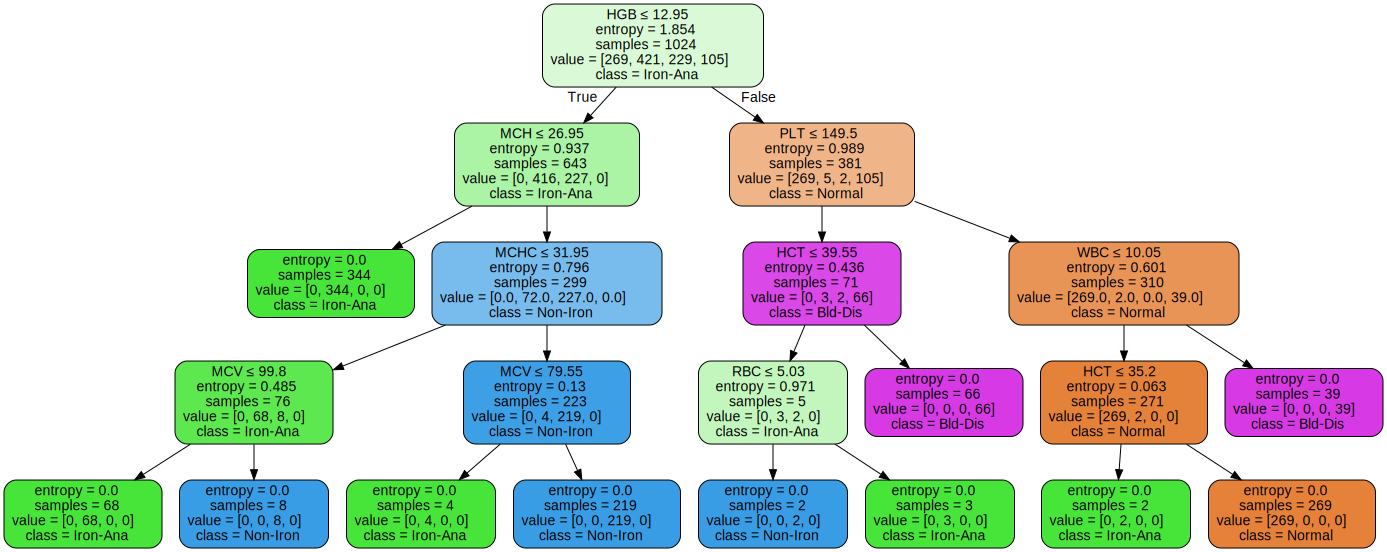

Decision Tree Graph for Max Depth 6:


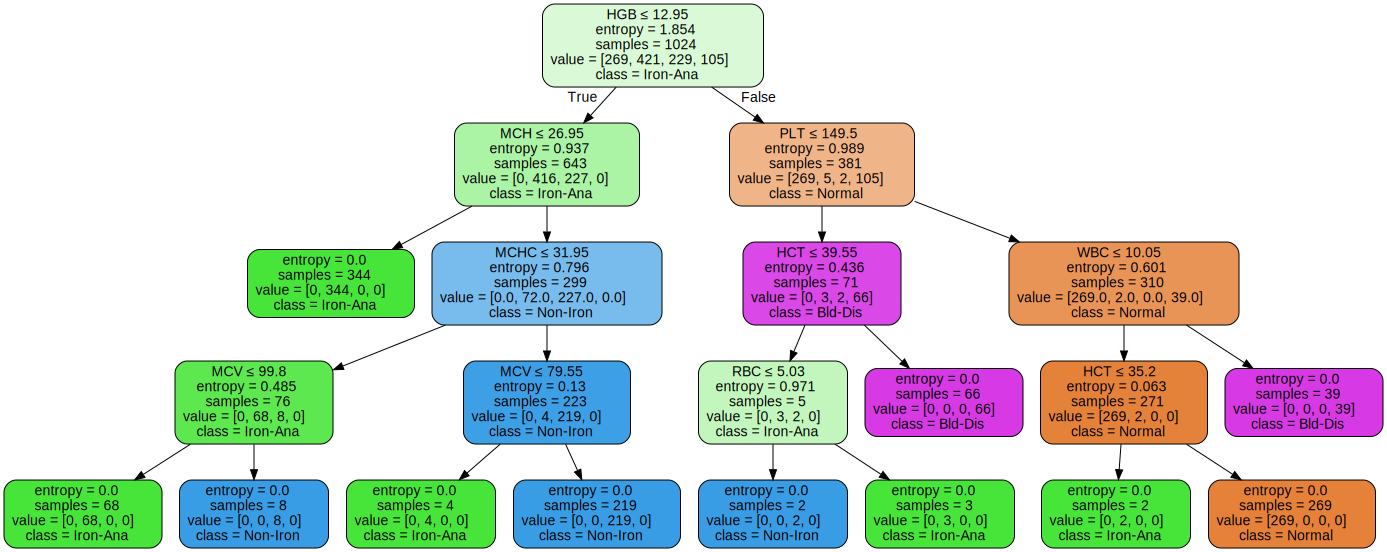

Decision Tree Graph for Max Depth 7:


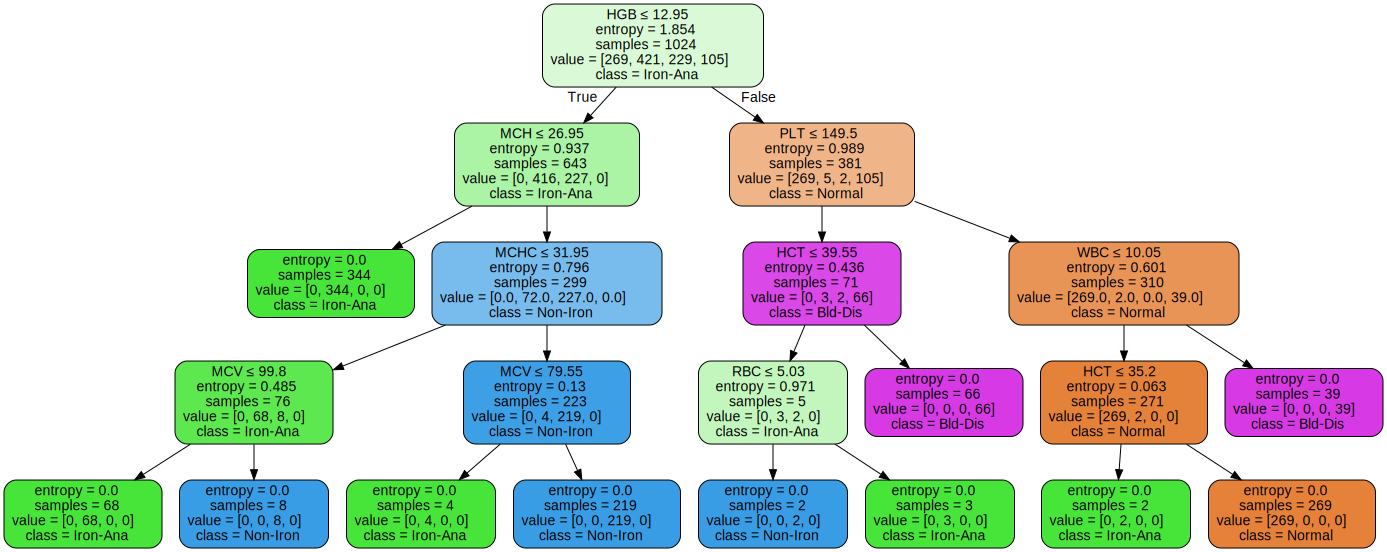

Max Depth Accuracy
None      0.9961
2         0.9066
3         0.9883
4         0.9961
5         0.9961
6         0.9961
7         0.9961


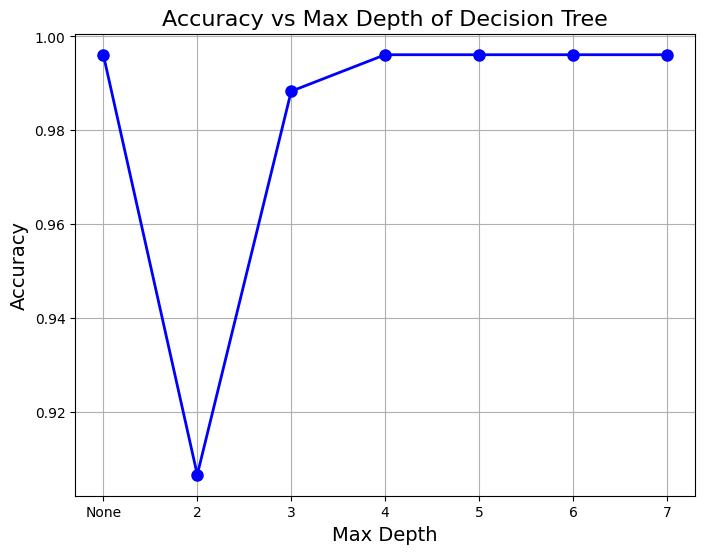

In [8]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
import graphviz

# Train and evaluate decision trees for max_depth values: None, 2, 3, 4, 5, 6, 7
max_depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracy_scores = []

# Prepare data (use 80/20 split)
X_train, X_test, y_train, y_test = splits["80_20"]

for max_depth in max_depth_values:
    # Train the decision tree classifier with the specified max_depth
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    
    # Export the tree to Graphviz format
    dot_data = export_graphviz(
        clf, 
        out_file=None,  # Output to string (DOT format)
        feature_names=data.drop(columns=["Diagnosis"]).columns,  # Feature names
        class_names=["Normal", "Iron-Ana", "Non-Iron", "Bld-Dis"],  # Target classes
        filled=True,  # Colorize nodes
        rounded=True,  # Rounded corners
        special_characters=True
    )


    graph = graphviz.Source(dot_data)
    graph.render(f"plots/dataset3/decision_tree_max_depth_{max_depth}", format="png") 
    print(f"Decision Tree Graph for Max Depth {max_depth}:")
    display(graph)

# Report the accuracy scores in a formatted table
print(f"{'Max Depth':<10}{'Accuracy'}")
for depth, accuracy in zip(max_depth_values, accuracy_scores):
    depth_str = "None" if depth is None else depth
    print(f"{depth_str:<10}{accuracy:.4f}")

# Plot the accuracy vs max_depth
plt.figure(figsize=(8, 6))
plt.plot([str(d) if d is not None else "None" for d in max_depth_values], accuracy_scores, 
         marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.title("Accuracy vs Max Depth of Decision Tree", fontsize=16)
plt.xlabel("Max Depth", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid(True)
plt.show()